In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder

In [2]:
apps = pd.read_csv('googleplaystore.csv')

### Data Cleaning
apps = apps.drop(apps.columns[apps.columns.str.contains('unnamed',case = False)],axis = 1)
apps = apps.drop_duplicates(subset=['App'])
apps = apps.dropna()
apps = apps[apps['Rating'] != 19]
#apps['Reviews'] = apps['Reviews'].map(lambda r: int(r))
#apps = apps[apps['Reviews'] < 20000000]
apps['Price'] = apps['Price'].map(lambda p: float(p.replace("$", "")))
#apps['Installs'] = apps['Installs'].map(lambda i: int(i[:-1].replace(",", "")))
apps = apps[apps['Price'] < 20]
def size_to_int(s):
    if 'k' in s:
        return float(s.replace("k", "")) / 1024
    elif 'M' in s:
        return float(s.replace("M", ""))
    
apps['Size'] = apps['Size'].map(size_to_int)
apps = apps.dropna()
# Export cleaned data
apps.to_csv('apps.csv')

# Remove unneeded columns
apps = apps.drop(columns=['Last Updated', 'Current Ver', 'Size', 'Genres', 'Android Ver', 'Type', 'Reviews', 'Installs'])


print('Totals:')
print(apps.shape)
print('%s app entries'  % len(apps))
print('%s unique categories' % len(apps['Category'].unique()))
print('%s unique content ratings' % len(apps['Content Rating'].unique()))
apps.head(3)

Totals:
(6995, 5)
6995 app entries
33 unique categories
6 unique content ratings


,App,Category,Rating,Price,Content Rating
0,Masha and the Bear: Evolution,FAMILY,4.5,0.0,Everyone
1,Official Matsumoto Kiyoshi application,LIFESTYLE,3.2,0.0,Everyone
2,autolina.ch has over 120'000 cars on offer.,AUTO_AND_VEHICLES,4.2,0.0,Everyone


In [3]:
reviews = pd.read_csv('googleplaystore_user_reviews.csv')

### Data Cleaning
# Drop rows with NaN in any column
reviews = reviews.dropna()
# Export cleaned data
reviews.to_csv('reviews.csv')

print('Totals:')
print(reviews.shape)
print('%s reviews'  % len(reviews))
print('%s unique apps' % len(reviews['App'].unique()))
print('Review sentiments: %s' % reviews['Sentiment'].unique())
reviews.head(3)

Totals:
(37427, 6)
37427 reviews
865 unique apps
Review sentiments: ['Neutral' 'Positive' 'Negative']


,Unnamed: 0,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,5320,Alarm Clock Free,Not working anymore,Neutral,0.000000,0.000000
1,3394,ASUS SuperNote,"I'm trying send feedback, texts appearing scre...",Neutral,0.000000,0.000000
3,30935,Crunchyroll - Everything Anime,"Great place good quality anime, quality bad ei...",Positive,0.133631,0.456548


In [4]:
# Create another dataframe with only apps that have reviews in the reviews dataset
unique_review_apps = reviews['App'].unique().tolist()
review_apps = apps[apps.App.isin(unique_review_apps)]
# Remove duplicates
review_apps = review_apps.drop_duplicates(subset=['App'])

# Add the mean polarity and subjectivity of each app as a column
mean_scores = reviews.groupby('App').mean()
review_apps['Polarity'] = review_apps['App'].map(lambda a: mean_scores.loc[a]['Sentiment_Polarity'])
review_apps['Subjectivity'] = review_apps['App'].map(lambda a: mean_scores.loc[a]['Sentiment_Subjectivity'])
print(review_apps.shape)
review_apps.head(10)

(567, 7)


,App,Category,Rating,Price,Content Rating,Polarity,Subjectivity
6,HISTORY: Watch TV Show Full Episodes & Specials,ENTERTAINMENT,4.1,0.0,Teen,0.211279,0.521122
40,Davis's Drug Guide,MEDICAL,3.9,0.0,Everyone,-0.100000,0.533333
42,Angry Birds 2,GAME,4.6,0.0,Everyone,0.002282,0.496239
63,COOKING MAMA Let's Cook!,FAMILY,4.3,0.0,Everyone,0.218922,0.505889
79,Hotspot Shield Free VPN Proxy & Wi-Fi Security,TOOLS,4.2,0.0,Everyone,0.251765,0.393284
101,CMB Free Dating App,DATING,4.0,0.0,Mature 17+,0.291757,0.542165
111,Fruit Block - Puzzle Legend,GAME,4.6,0.0,Everyone,-0.183333,0.377778
116,Free & Premium VPN - FinchVPN,TOOLS,4.2,0.0,Everyone,0.217669,0.477773
170,Google News,NEWS_AND_MAGAZINES,3.9,0.0,Teen,0.093917,0.496776
181,Garden Photo Frames - Garden Photo Editor,PHOTOGRAPHY,4.4,0.0,Everyone,0.342137,0.493718


In [5]:
def replace_dummies(df, columns):
    dummies = [pd.get_dummies(review_apps[c]) for c in columns]
    return pd.concat([df.drop(columns=columns)] + dummies, axis=1)

rx = np.linspace(-0.5, 1)
ry = rx + 4

#review_apps = replace_dummies(review_apps, ['Category', 'Content Rating'])
review_apps = review_apps.drop(columns=['Category', 'Content Rating'])
review_apps.head(3)

,App,Rating,Price,Polarity,Subjectivity
6,HISTORY: Watch TV Show Full Episodes & Specials,4.1,0.0,0.211279,0.521122
40,Davis's Drug Guide,3.9,0.0,-0.100000,0.533333
42,Angry Birds 2,4.6,0.0,0.002282,0.496239


In [6]:
# Move ratings into its own vector
ratings = review_apps['Rating'].values
names = review_apps['App'].values
input_apps = review_apps.drop(columns=['App', 'Rating'])
print(input_apps.shape)
input_apps.head(3)

(567, 3)


,Price,Polarity,Subjectivity
6,0.0,0.211279,0.521122
40,0.0,-0.100000,0.533333
42,0.0,0.002282,0.496239


[-0.06664863 -0.00496394 -0.33848865]
variance: 0.10435860681032705
correlation: 0.32304582772468526


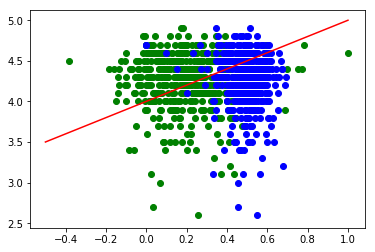

In [19]:
train_x, test_x = train_test_split(input_apps, test_size=0.9)
train_y, test_y = train_test_split(ratings, test_size=0.9)

regr = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
regr.fit(train_x, train_y)
print(-regr.coef_)
var = -regr.score(test_x, test_y)

plt.scatter(test_x['Polarity'], test_y, color='g')
plt.scatter(test_x['Subjectivity'], test_y, color='b')
plt.plot(rx, ry, color='r')
print('variance: %s' % var)
print('correlation: %s' % math.sqrt(var))